In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import sys
sys.path.insert(0, '/content/drive/My Drive')

import torch
import numpy as np
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms
from torchvision.transforms import InterpolationMode
from torch.utils.data import DataLoader
import torch.optim as optim
import torch.nn as nn

In [3]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Running on {DEVICE}')

NUM_CLASSES = 19    

BATCH_SIZE = 8     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 0.05            # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 5e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 5   # Total number of training epochs (iterations over dataset)
STEP_SIZE = 4    # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.1          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 40

Running on cuda


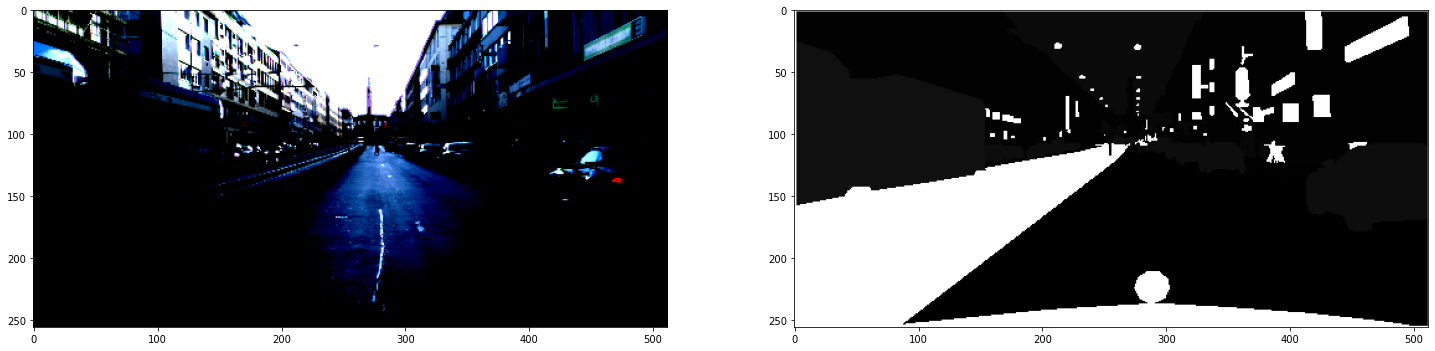

In [4]:
from Cityscapes import Cityscapes

mean = [0.3257, 0.3690, 0.3223]
std = [0.2112, 0.2148, 0.2115]
normalizer = transforms.Normalize(mean=mean, std=std)
resizer_bicubic = transforms.Resize((256, 512), interpolation=InterpolationMode.BICUBIC)
resizer_nearest = transforms.Resize((256, 512), interpolation=InterpolationMode.NEAREST)

train_transform = transforms.Compose([normalizer, resizer_bicubic])
eval_transform = transforms.Compose([normalizer, resizer_bicubic])
target_transform = transforms.Compose([resizer_nearest])

train_dataset = Cityscapes('drive/MyDrive/', partition_type='A', split='train', transform=train_transform, target_transform=target_transform)
test_dataset = Cityscapes('drive/MyDrive/', partition_type='A', split='val', transform=eval_transform, target_transform=target_transform)

i, l = train_dataset.__getitem__(101)
fig = plt.figure(figsize=(25, 15))
fig.add_subplot(1, 2, 1)
plt.imshow(i.permute(1, 2, 0))
fig.add_subplot(1, 2, 2)
plt.imshow(l.permute(1, 2, 0)[..., 0], cmap='gray')
plt.show()

In [5]:
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [6]:
from bisenetv2 import BiSeNetV2

net = BiSeNetV2(NUM_CLASSES, output_aux=False, pretrained=False)
net = net.to(DEVICE)

In [7]:
# Define loss function
criterion = nn.CrossEntropyLoss(ignore_index=255) # for classification, we use Cross Entropy

# Choose parameters to optimize
# To access a different set of parameters, you have to access submodules of the net
# (nn.Module objects implement the Composite Pattern)
# e.g.: parameters of the fully connected layers: net.classifier.parameters()
# e.g.: parameters of the convolutional layers
parameters_to_optimize = net.parameters() # In this case we optimize over all the parameters

# Define optimizer
optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)

# Define scheduler
# A scheduler dynamically changes learning rate
# The most common schedule is the step(-down), which multiplies learning rate by gamma every STEP_SIZE epochs
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=GAMMA)

In [8]:
!pip install torchmetrics
import torchmetrics
from torchmetrics.classification import MulticlassJaccardIndex
metric = MulticlassJaccardIndex(num_classes=NUM_CLASSES, ignore_index=255).to(DEVICE)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [9]:
colors = [
  [128, 64, 128],
  [244, 35, 232],
  [70, 70, 70],
  [102, 102, 156],
  [190, 153, 153],
  [153, 153, 153],
  [250, 170, 30],
  [220, 220, 0],
  [107, 142, 35],
  [152, 251, 152],
  [0, 130, 180],
  [220, 20, 60],
  [255, 0, 0],
  [0, 0, 142],
  [0, 0, 70],
  [0, 60, 100],
  [0, 80, 100],
  [0, 0, 230],
  [119, 11, 32]    
]

label_colours = dict(zip(range(NUM_CLASSES), colors))

def decode_segmap(image):
  #convert gray scale to color
  image=image.numpy()
  r = image.copy()
  g = image.copy()
  b = image.copy()
  for l in range(0, NUM_CLASSES):
    r[image == l] = label_colours[l][0]
    g[image == l] = label_colours[l][1]
    b[image == l] = label_colours[l][2]

  rgb = np.zeros((image.shape[0], image.shape[1], 3))
  rgb[:, :, 0] = r / 255.0
  rgb[:, :, 1] = g / 255.0
  rgb[:, :, 2] = b / 255.0
  return rgb

In [10]:
def display_prediction(random=False):
    if random == True:
      dl = DataLoader(test_dataset, batch_size=1, shuffle=True)
    else:
      dl = DataLoader(test_dataset, batch_size=1, shuffle=False)
    for (i, l) in dl:
      break

    fig = plt.figure(figsize=(20, 10))

    fig.add_subplot(1, 3, 1)
    plt.imshow(i[0].permute(1, 2, 0))
    plt.axis('off')

    fig.add_subplot(1, 3, 2)
    l = l[0].squeeze()
    l = decode_segmap(l)
    plt.imshow(l)

    net.eval()
    with torch.no_grad():
      i = i.to(DEVICE)
      out = net(i)
      out = torch.softmax(out, dim=1)
      out = torch.argmax(out, dim=1)
      out = out.cpu().squeeze()

      fig.add_subplot(1, 3, 3)
      out = decode_segmap(out)
      plt.imshow(out)
    plt.show()

In [11]:
def train_epoch(net, dataloader, lr=0.01, optimizer=optimizer, loss_fn=criterion):
    net.train()

    total_loss, miou, count = 0, 0, 0
    for i, (images, masks) in enumerate(dataloader):
        images = images.to(DEVICE, dtype=torch.float32)
        masks = masks.squeeze().to(DEVICE, dtype=torch.long)
        optimizer.zero_grad()

        out = net(images)
        loss = loss_fn(out, masks) 
        loss.backward()
        optimizer.step()

        total_loss += loss
        miou += metric(out, masks)
        count += 1
        if i%LOG_FREQUENCY == 0:
          print("  minibatch {}: train mIoU = {} train loss = {}".format(i, miou.item()/count, total_loss.item()/count))
    return total_loss.item()/count, miou.item()/count

def validate(net, dataloader, loss_fn=criterion):
    net.eval()
    loss, miou, count = 0, 0, 0
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(DEVICE)
            masks = masks.squeeze().to(DEVICE)

            out = net(images)
            loss += loss_fn(out, masks) 
            miou += metric(out, masks)
            count += 1
    return loss.item()/count, miou.item()/count

def train(net, train_loader, test_loader, optimizer=optimizer, lr=0.01, epochs=10, loss_fn=criterion):
    result = {'train_loss' : [], 'train_miou': [], 'val_loss': [], 'val_miou': []}

    print(f'Lr: {lr}\nEpochs: {epochs}\nLoss function: {loss_fn}\nOptimizer: {optimizer}')

    for ep in range(epochs):
        print(f'----------- EPOCH {ep+1} -----------')
        train_loss, train_miou = train_epoch(net, train_loader, optimizer=optimizer, lr=lr, loss_fn=loss_fn)
        val_loss, val_miou = validate(net, test_loader, loss_fn=loss_fn)
        print(f"Train mIoU={train_miou:.3f}, Val mIoU={val_miou:.3f}, Train loss={train_loss:.3f}, Val loss={val_loss:.3f}")
        result['train_loss'].append(train_loss)
        result['train_miou'].append(train_miou)
        result['val_loss'].append(val_loss)
        result['val_miou'].append(val_miou)
        display_prediction()
        scheduler.step()
    return result

def plot_results(history):
    plt.figure(figsize=(15,5))
    plt.subplot(121)
    plt.plot(history['train_miou'], label='Training mIoU')
    plt.plot(history['val_miou'], label='Validation mIoU')
    plt.legend()
    plt.subplot(122)
    plt.plot(history['train_loss'], label='Training loss')
    plt.plot(history['val_loss'], label='Validation loss')
    plt.legend()

Lr: 0.05
Epochs: 5
Loss function: CrossEntropyLoss()
Optimizer: SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    initial_lr: 0.05
    lr: 0.05
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 5e-05
)
----------- EPOCH 1 -----------
  minibatch 0: train mIoU = 0.014000046998262405 train loss = 3.3956496715545654
  minibatch 40: train mIoU = 0.07853449844732517 train loss = 1.8323114906869284
  minibatch 80: train mIoU = 0.1048820048202703 train loss = 1.4531639004931038
Train mIoU=0.108, Val mIoU=0.138, Train loss=1.415, Val loss=1.076


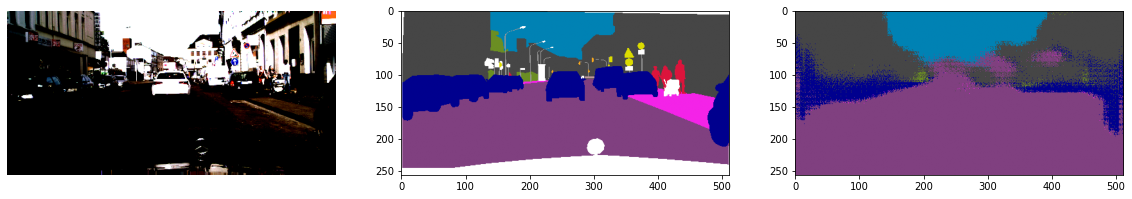

----------- EPOCH 2 -----------
  minibatch 0: train mIoU = 0.16078174114227295 train loss = 0.8812793493270874
  minibatch 40: train mIoU = 0.156586402800025 train loss = 0.9072208869748
  minibatch 80: train mIoU = 0.16284329214213808 train loss = 0.8758611796814718
Train mIoU=0.164, Val mIoU=0.154, Train loss=0.873, Val loss=0.954


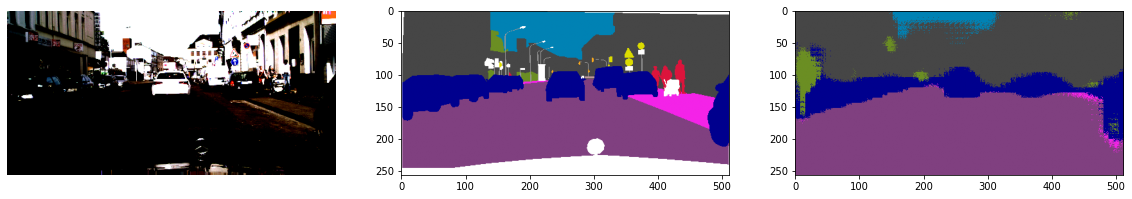

----------- EPOCH 3 -----------
  minibatch 0: train mIoU = 0.1602473258972168 train loss = 0.918501079082489
  minibatch 40: train mIoU = 0.18211142609759076 train loss = 0.7944561097680068
  minibatch 80: train mIoU = 0.18577838238374686 train loss = 0.76424045327269
Train mIoU=0.186, Val mIoU=0.157, Train loss=0.763, Val loss=0.925


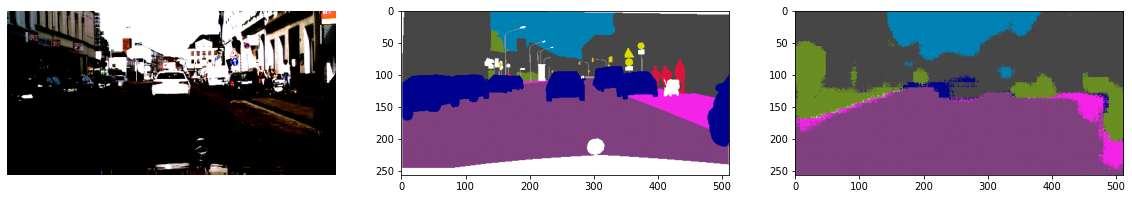

----------- EPOCH 4 -----------
  minibatch 0: train mIoU = 0.18555574119091034 train loss = 0.7507584095001221
  minibatch 40: train mIoU = 0.19824872365811977 train loss = 0.7082996833615187
  minibatch 80: train mIoU = 0.20126721888412663 train loss = 0.7085835492169416
Train mIoU=0.202, Val mIoU=0.188, Train loss=0.708, Val loss=0.800


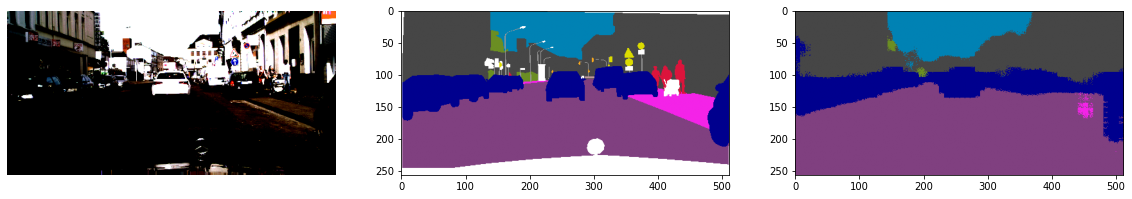

----------- EPOCH 5 -----------
  minibatch 0: train mIoU = 0.19620077311992645 train loss = 0.7554380297660828
  minibatch 40: train mIoU = 0.21542253726866187 train loss = 0.6685601211175686
  minibatch 80: train mIoU = 0.2184827357162664 train loss = 0.6406906033739631
Train mIoU=0.219, Val mIoU=0.219, Train loss=0.637, Val loss=0.643


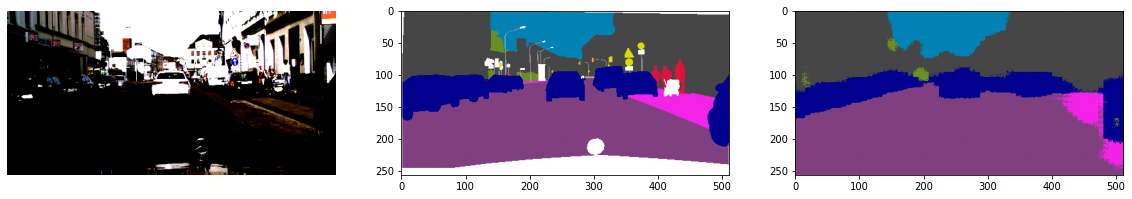

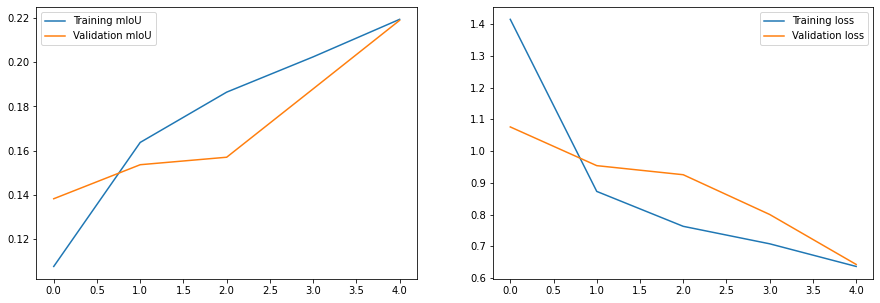

In [12]:
history = train(net, train_dataloader, val_dataloader, optimizer=optimizer, lr=LR, epochs=NUM_EPOCHS)
plot_results(history)

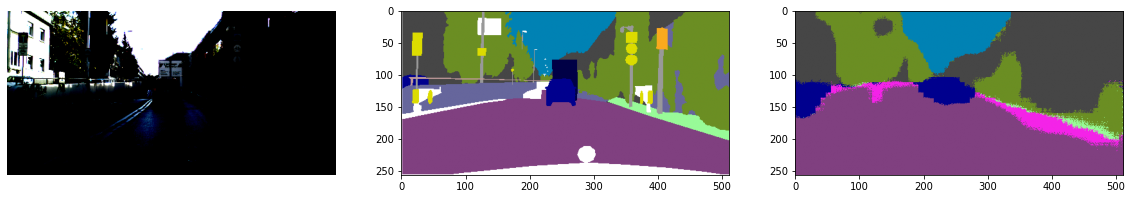

In [16]:
display_prediction(random=True)